<a href="https://colab.research.google.com/github/zaaraquadrii/Zaara_Projects_Labs/blob/main/Module_01_Lab_03_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X / 255
test_X = test_X / 255

train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def NN1(traindata, trainlabel, query):
    diff = (
        traindata - query
    )
    sq = diff * diff
    dist = sq.sum(1)
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [4]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

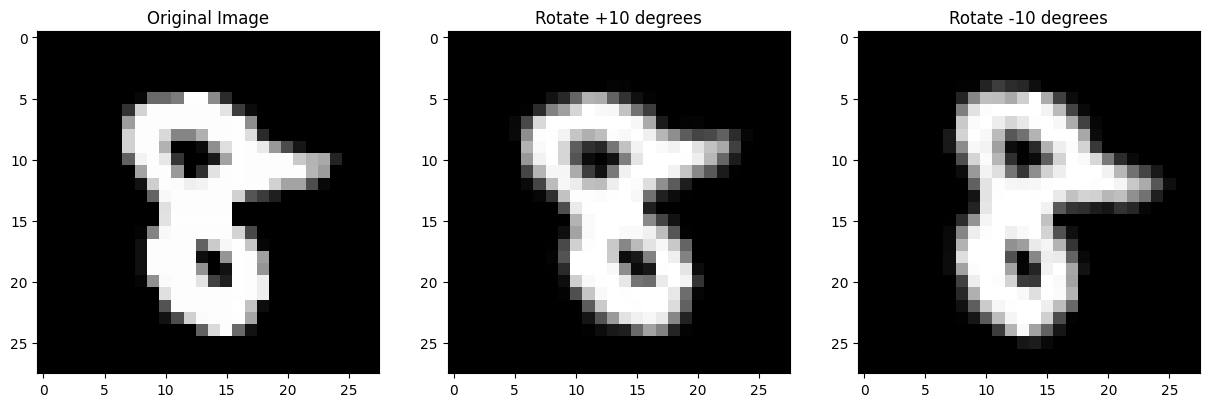

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [6]:
def augRotate(sample, angleconstraint):
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

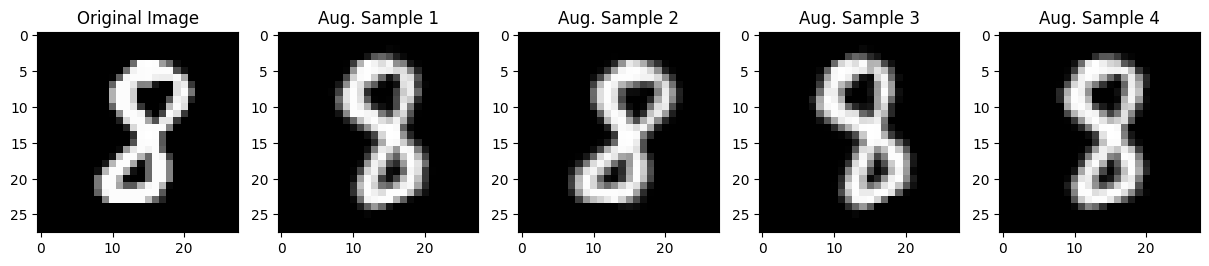

In [7]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [9]:
angleconstraint = 60
naugmentations = 5

augdata = train_X
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )
    auglabel = np.concatenate(
        (auglabel, train_y)
    )
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.66 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [10]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)

for ii in range(len(angleconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )
        auglabel = np.concatenate(
            (auglabel, train_y)
        )
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

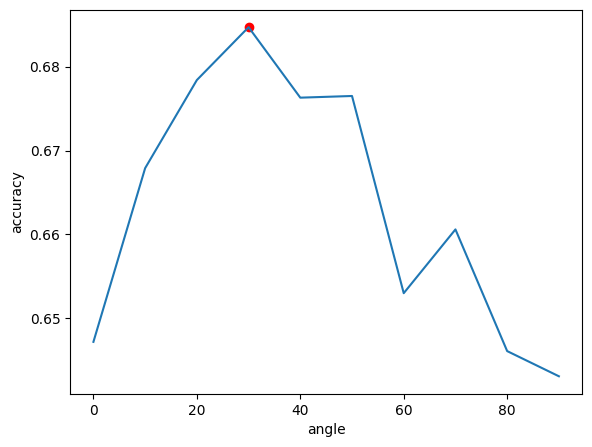

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [12]:
def shear(sample, amount):
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

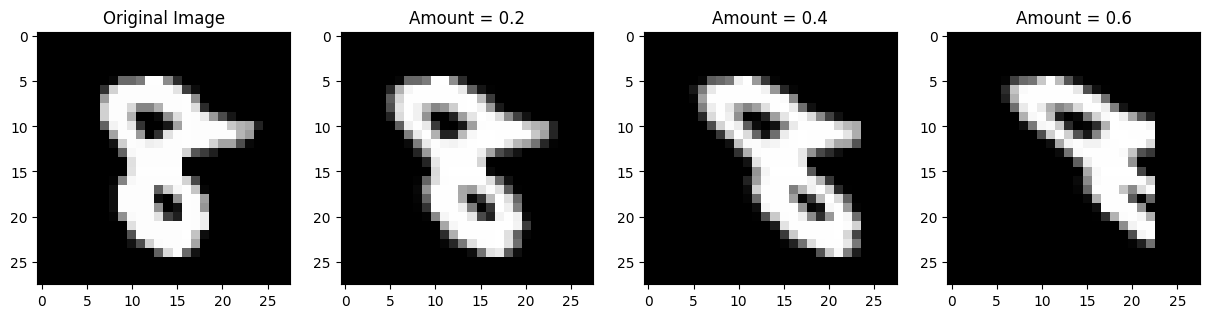

In [13]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [14]:
def augShear(sample, shearconstraint):
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)

Let us do a grid search to find the best shear constraint.

In [15]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)

for ii in range(len(shearconstraints)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )
        auglabel = np.concatenate(
            (auglabel, train_y)
        )
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.79 %
Accuracy after shear augmentation constrained by 0.4 is 64.41 %
Accuracy after shear augmentation constrained by 0.6 is 65.71000000000001 %
Accuracy after shear augmentation constrained by 0.8 is 65.78 %
Accuracy after shear augmentation constrained by 1.0 is 65.42999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.6 %
Accuracy after shear augmentation constrained by 1.4 is 63.65 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.029999999999994 %
Accuracy after shear augmentation constrained by 2.0 is 64.14 %


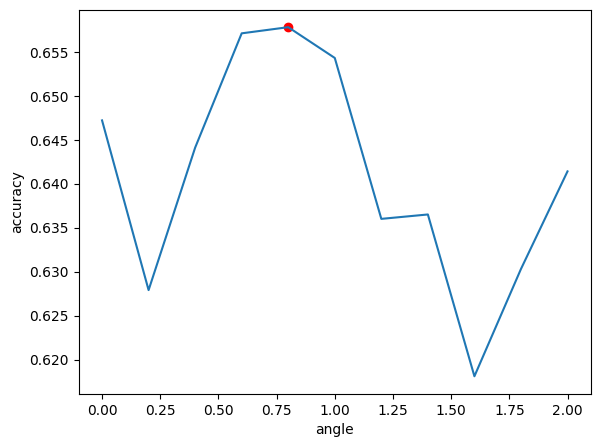

In [16]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [17]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )
    return np.squeeze(nsample)

In [18]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]
angleconstraints = [0, 10, 20, 30, 40, 50, 60]
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)

for ii in range(len(hyp)):
    augdata = train_X
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )
        auglabel = np.concatenate(
            (auglabel, train_y)
        )
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 63.959999999999994 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 60.64000000000001 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 63.019999999999996 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 64.14999999999999 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 61.72 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 63.7 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.41 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 61.25000000000001 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 60.6 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 60.07 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 63.690000000000005 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 60.12 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 63.72 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.37000

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

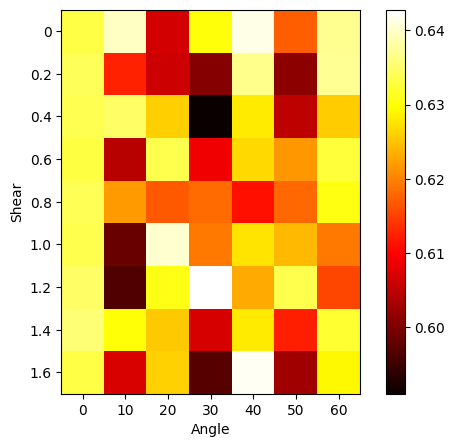

In [19]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

## Questions
Try these questions for better understanding. You may not be able to solve all of them.
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is <a href=https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/>here. </a>
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

In [20]:
max_accuracy_index = np.argmax(accuracies)
best_shear = hyp[max_accuracy_index][0]
best_angle = hyp[max_accuracy_index][1]
max_accuracy = accuracies[max_accuracy_index] * 100
baseline_accuracy = 80.0
accuracy_improvement = max_accuracy - baseline_accuracy

print(f"Best Shear Constraint: {best_shear}")
print(f"Best Angle Constraint: {best_angle}")
print(f"Maximum Accuracy with Rotation and Shear Augmentation: {max_accuracy:.2f}%")
print(f"Accuracy Improvement compared to no augmentation: {accuracy_improvement:.2f}%")

Best Shear Constraint: 1.2
Best Angle Constraint: 30.0
Maximum Accuracy with Rotation and Shear Augmentation: 64.28%
Accuracy Improvement compared to no augmentation: -15.72%


Accuracy with 1 augmentations: 60.77%
Accuracy with 2 augmentations: 62.06%
Accuracy with 5 augmentations: 61.60%
Accuracy with 10 augmentations: 64.67%
Accuracy with 20 augmentations: 63.38%


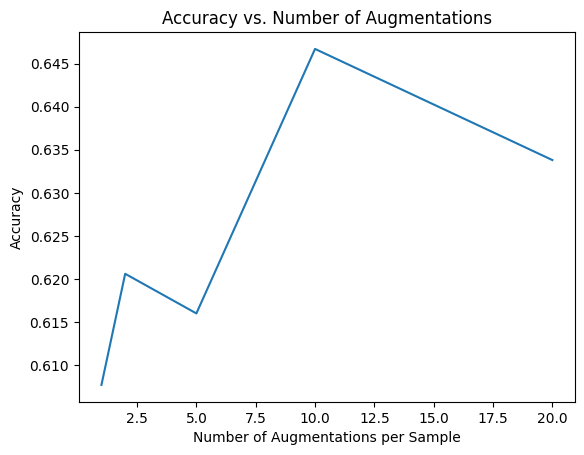

In [21]:
n_augmentations_to_test = [1, 2, 5, 10, 20]
accuracies_n_aug = []

angle_constraint = 60
shear_constraint = 0.4

for n_aug in n_augmentations_to_test:
    augdata = train_X.copy()
    auglabel = train_y.copy()
    for _ in range(n_aug):
        augdata = np.concatenate((augdata, augRotateShear(train_X, shear_constraint, angle_constraint)))
        auglabel = np.concatenate((auglabel, train_y))

    testpred = NN(augdata, auglabel, test_X)
    accuracy = Accuracy(test_y, testpred)
    accuracies_n_aug.append(accuracy)
    print(f"Accuracy with {n_aug} augmentations: {accuracy*100:.2f}%")

plt.figure()
plt.plot(n_augmentations_to_test, accuracies_n_aug)
plt.xlabel("Number of Augmentations per Sample")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Augmentations")
plt.show()

In [22]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    input_is_2d = False
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
        input_is_2d = True

    amt = rng.random(len(sample))
    amt = (amt - 0.5) * shearconstraint
    angle = rng.random(len(sample))
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )

    if input_is_2d:
        return np.squeeze(nsample)
    else:
        return nsample

def augTranslate(sample, translate_range):
    input_is_2d = False
    if len(sample.shape) == 2:
        sample = np.expand_dims(sample, 0)
        input_is_2d = True

    nsample = sample.copy()
    for ii in range(len(sample)):
        ty = rng.integers(-translate_range, translate_range + 1)
        tx = rng.integers(-translate_range, translate_range + 1)
        nsample[ii] = np.roll(nsample[ii], (ty, tx), axis=(0, 1))

    if input_is_2d:
        return np.squeeze(nsample)
    else:
        return nsample

Accuracy with 100% of data: 55.57%
Accuracy with 80% of data: 57.34%
Accuracy with 60% of data: 53.99%
Accuracy with 40% of data: 48.15%
Accuracy with 20% of data: 33.89%
Accuracy with 10% of data: 24.54%
Accuracy with 5% of data: 15.27%
Accuracy with 2% of data: 8.92%


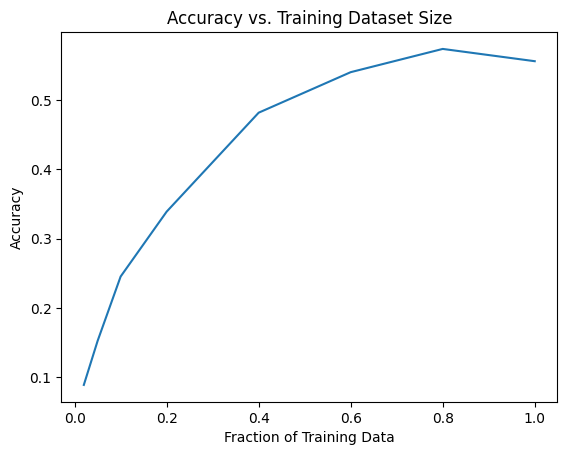

Smallest fraction of data for >50% accuracy: 100%


In [23]:
def augCombined(sample, angleconstraint, shearconstraint, translate_range):
    sample = augRotateShear(sample, angleconstraint, shearconstraint)
    sample = augTranslate(sample, translate_range)
    return sample

dataset_fractions = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.02]
accuracies_dataset_size = []

best_angle = 30
best_shear = 0.4
best_translate = 5
n_augmentations = 5

for fraction in dataset_fractions:
    num_samples = int(len(train_X) * fraction)
    sub_train_X = train_X[:num_samples].copy()
    sub_train_y = train_y[:num_samples].copy()

    augdata = sub_train_X.copy()
    auglabel = sub_train_y.copy()
    for _ in range(n_augmentations):
         augdata = np.concatenate((augdata, augCombined(sub_train_X, best_angle, best_shear, best_translate)))
         auglabel = np.concatenate((auglabel, sub_train_y))


    testpred = NN(augdata, auglabel, test_X)
    accuracy = Accuracy(test_y, testpred)
    accuracies_dataset_size.append(accuracy)
    print(f"Accuracy with {fraction*100:.0f}% of data: {accuracy*100:.2f}%")

plt.figure()
plt.plot(dataset_fractions, accuracies_dataset_size)
plt.xlabel("Fraction of Training Data")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Training Dataset Size")
plt.show()

for i, acc in enumerate(accuracies_dataset_size):
    if acc * 100 > 50:
        smallest_fraction = dataset_fractions[i]
        print(f"Smallest fraction of data for >50% accuracy: {smallest_fraction*100:.0f}%")
        break

## Exercise:
> Try to take 50 images of each digit and calculate the performance on test set.

In [24]:
sub_train_X = []
sub_train_y = []
num_images_per_digit = 50

for digit in range(10):
    indices = np.where(train_y == digit)[0]
    selected_indices = indices[:num_images_per_digit]
    sub_train_X.append(train_X[selected_indices])
    sub_train_y.append(train_y[selected_indices])

sub_train_X = np.concatenate(sub_train_X)
sub_train_y = np.concatenate(sub_train_y)

testpred_sub = NN(sub_train_X, sub_train_y, test_X)

accuracy_sub = Accuracy(test_y, testpred_sub)
print(f"Accuracy with 50 images per digit: {accuracy_sub * 100:.2f}%")

Accuracy with 50 images per digit: 64.72%
